## Transformerによる極値予測

In [25]:
# Step 1: 環境セットアップ（Google Driveマウント＋ライブラリインポート）
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Drive mount skipped")
import math, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, f1_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Step 2: ファイルパス定義
TRAIN_PATH = "/content/drive/MyDrive/TSAT/BTC_5min/BTC_full_5min_Train.csv"
VALID_PATH = "/content/drive/MyDrive/TSAT/BTC_5min/BTC_full_5min_Valid.csv"

In [9]:
# Step 3: 再現性確保のためのシード固定
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
# Step 4: データ読み込み＆補間関数定義
def load_and_interpolate(path):
    df = pd.read_csv(path, parse_dates=['date']).set_index('date').sort_index()
    idx = pd.date_range(df.index.min(), df.index.max(), freq='5T')
    return df.reindex(idx).interpolate(method='time')


In [13]:
# Step 5: データ読み込み実行＋期間フィルタリング
df_train = load_and_interpolate(TRAIN_PATH)
df_valid = load_and_interpolate(VALID_PATH)
df_train = df_train[df_train.index >= '2020-01-01']
print("Train:", df_train.index.min(), "to", df_train.index.max())
print("Valid:", df_valid.index.min(), "to", df_valid.index.max())

<ipython-input-10-d642c708a959>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  idx = pd.date_range(df.index.min(), df.index.max(), freq='5T')


Train: 2020-01-01 00:00:00 to 2022-12-31 23:55:00
Valid: 2023-01-01 00:00:00 to 2023-12-14 23:55:00


<ipython-input-10-d642c708a959>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  idx = pd.date_range(df.index.min(), df.index.max(), freq='5T')


In [26]:
# Step 5: ハードラベル生成 (前後 k=6)
def make_hard_labels(lows, highs, k=6):
    n = len(lows)
    lbl = np.zeros(n, dtype=int)
    for t in range(k, n-k):
        if lows[t] < lows[t-k:t].min() and lows[t] < lows[t+1:t+k+1].min():
            lbl[t] = 1
        elif highs[t] > highs[t-k:t].max() and highs[t] > highs[t+1:t+k+1].max():
            lbl[t] = 2
    return lbl

lows_train, highs_train = df_train['low'].values, df_train['high'].values
lows_val, highs_val     = df_valid['low'].values, df_valid['high'].values
hard_train = make_hard_labels(lows_train, highs_train, k=6)
hard_val   = make_hard_labels(lows_val, highs_val, k=6)
df_train['hard_label'] = hard_train
df_valid['hard_label'] = hard_val

In [97]:
# Step 6: スコアベースソフトラベリング関数
def compute_scores(lows, highs, k=6):
    n = len(lows)
    s_min = np.zeros(n)
    s_max = np.zeros(n)
    for t in range(k, n-k):
        # 極小度
        s_min[t] = 100*np.mean((lows[t-k:t] - lows[t]) / lows[t-k:t] +
                           (lows[t+1:t+k+1] - lows[t]) / lows[t+1:t+k+1])
        # 極大度
        s_max[t] = 100*np.mean((highs[t] - highs[t-k:t]) / highs[t-k:t] +
                           (highs[t] - highs[t+1:t+k+1]) / highs[t+1:t+k+1])
    return s_min, s_max

smin_train, smax_train = compute_scores(lows_train, highs_train, k=6)
smin_val, smax_val     = compute_scores(lows_val, highs_val, k=6)

def soft_label_from_scores(smin, smax):
    # baseline for Other = 1.0
    # logits = np.stack([np.ones_like(smin), smin, smax], axis=1)
    logits = np.stack([1.5-np.maximum(smin, smax), smin, smax], axis=1) # other をsmin-smax
    exp = np.exp(logits)
    return exp / exp.sum(axis=1, keepdims=True)

soft_train = soft_label_from_scores(smin_train, smax_train)
soft_val   = soft_label_from_scores(smin_val, smax_val)
df_train['soft_label'] = list(soft_train)
df_valid['soft_label'] = list(soft_val)

In [98]:
# Step 7: シーケンス特徴量 & ラベル生成 (SEQ_LEN=288)
SEQ_LEN = 288
def make_dataset(df, hard_lbl, soft_lbl):
    X, y_hard, y_soft = [], [], []
    for t in range(SEQ_LEN-1, len(df)-6):
        win = df.iloc[t-SEQ_LEN+1:t+1]
        c0 = win['close'].iloc[-1]
        feats = np.stack([win['close']/c0,
                          win['high'] /c0,
                          win['low']  /c0,
                          win['volume']/c0], axis=1)
        X.append(feats)
        y_hard.append(hard_lbl[t])
        y_soft.append(soft_lbl[t])
    return np.array(X, dtype=np.float32), np.array(y_hard), np.array(y_soft, dtype=np.float32)

X_tr, y_tr_hard, y_tr_soft = make_dataset(df_train, hard_train, soft_train)
X_val_all, y_val_hard_all, y_val_soft_all = make_dataset(df_valid, hard_val, soft_val)
mid = len(X_val_all)//2
X_val, y_val_hard, y_val_soft = X_val_all[:mid], y_val_hard_all[:mid], y_val_soft_all[:mid]
X_test, y_test_hard, y_test_soft = X_val_all[mid:], y_val_hard_all[mid:], y_val_soft_all[mid:]

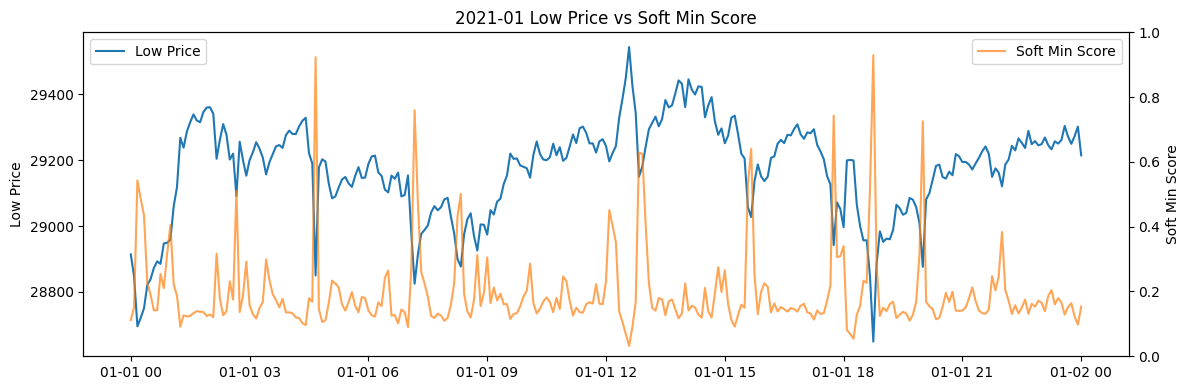

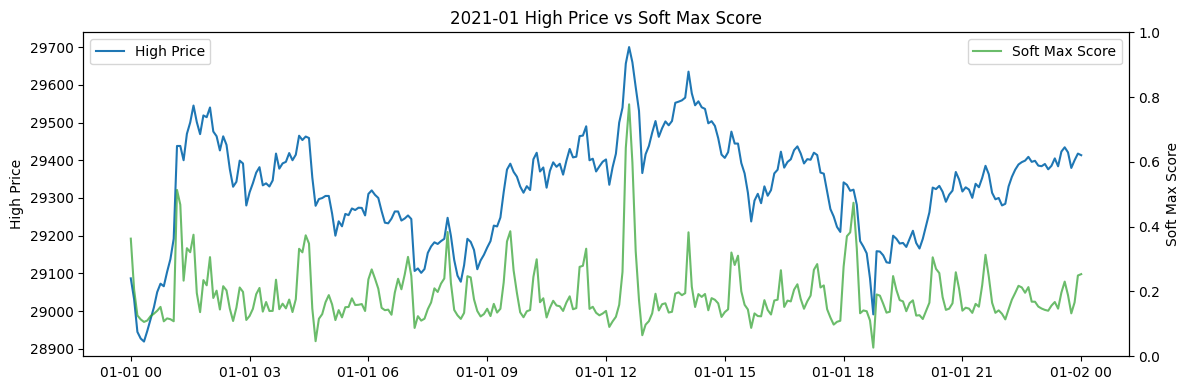

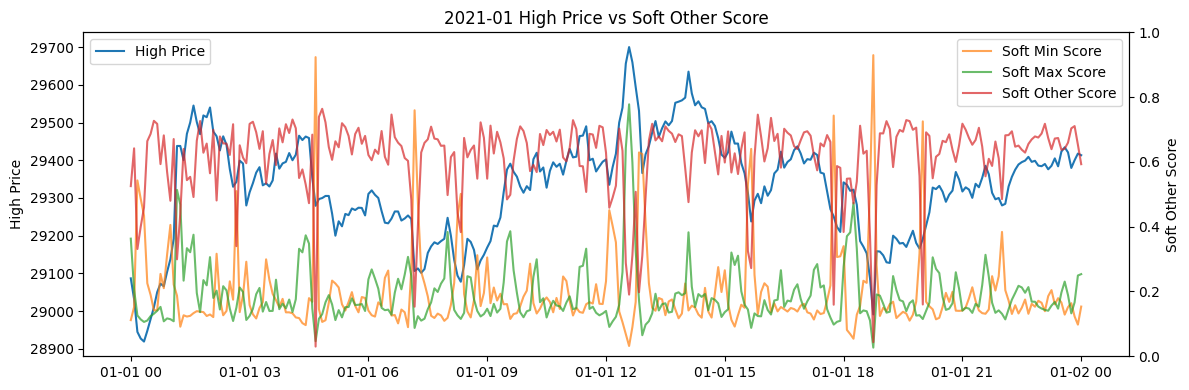

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- ソフトラベルを numpy array に展開 ---
soft_array = np.array(df_train['soft_label'].tolist())
soft_other = soft_array[:, 0]
soft_min   = soft_array[:, 1]
soft_max   = soft_array[:, 2]

# --- タイムインデックスと価格 ---
times       = df_train.index
low_series  = df_train['low']
high_series = df_train['high']

# --- プロット範囲を 2021-01-01 ～ 2021-01-31 に限定 ---
start, end = pd.to_datetime("2021-01-01"), pd.to_datetime("2021-01-02")
mask = (times >= start) & (times <= end)

# --- 抽出 ---
times_f        = times[mask]
low_f          = low_series[mask]
high_f         = high_series[mask]
soft_min_f     = soft_min[mask]
soft_max_f     = soft_max[mask]
soft_other_f   = soft_other[mask]

# --- プロット1: Low Price vs Soft Min Score ---
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(times_f, low_f, label='Low Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(times_f, soft_min_f, label='Soft Min Score', color='tab:orange', alpha=0.7)
ax2.set_ylim(0,1)
ax1.set_title('2021-01 Low Price vs Soft Min Score')
ax1.set_ylabel('Low Price')
ax2.set_ylabel('Soft Min Score')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --- プロット2: High Price vs Soft Max Score ---
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(times_f, high_f, label='High Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(times_f, soft_max_f, label='Soft Max Score', color='tab:green', alpha=0.7)
ax2.set_ylim(0,1)
ax1.set_title('2021-01 High Price vs Soft Max Score')
ax1.set_ylabel('High Price')
ax2.set_ylabel('Soft Max Score')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --- プロット3: Close vs Soft Other Score ---
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(times_f, high_f, label='High Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(times_f, soft_min_f, label='Soft Min Score', color='tab:orange', alpha=0.7)
ax2.plot(times_f, soft_max_f,label='Soft Max Score', color='tab:green', alpha=0.7)
ax2.plot(times_f, soft_other_f, label='Soft Other Score', color='tab:red', alpha=0.7)
ax2.set_ylim(0,1)
ax1.set_title('2021-01 High Price vs Soft Other Score')
ax1.set_ylabel('High Price')
ax2.set_ylabel('Soft Other Score')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [100]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 前提: df_train, y_tr_soft, SEQ_LEN が定義済み ---
# 時系列データとソフトラベルスコアの抽出
times = df_train.index[SEQ_LEN-1 : len(df_train)-6]
low_series  = df_train['low'].iloc[SEQ_LEN-1 : len(df_train)-6]
high_series = df_train['high'].iloc[SEQ_LEN-1 : len(df_train)-6]
import matplotlib.pyplot as plt
import pandas as pd

# --- 前提: df_train, y_tr_soft, SEQ_LEN が定義済み ---

# 時系列データとソフトラベルスコアの抽出
times = df_train.index[SEQ_LEN-1 : len(df_train)-6]
low_series  = df_train['low'].iloc[SEQ_LEN-1 : len(df_train)-6]
high_series = df_train['high'].iloc[SEQ_LEN-1 : len(df_train)-6]

# pandas Series から numpy array に変換
soft_array = np.array(df_train['soft_label'].tolist())
soft_min   = soft_array[:, 1]
soft_max   = soft_array[:, 2]
soft_other = soft_array[:, 0]

# プロット範囲を 2021-01-01 00:00 〜 2021-01-01 12:00 に限定
start = pd.to_datetime("2021-01-01 00:00")
end   = pd.to_datetime("2021-01-01 12:00")
mask = (times >= start) & (times <= end)

times_f      = times[mask]
low_f        = low_series[mask]
high_f       = high_series[mask]
soft_min_f   = soft_min[mask]
soft_max_f   = soft_max[mask]
soft_other_f = soft_other[mask]

# --- プロット1: Low Price vs Soft Min Score ---
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(times_f, low_f, label='Low Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(times_f, soft_min_f, label='Soft Min Score', color='tab:orange', alpha=0.8)
ax1.set_title('2021-01-01 00:00～12:00 Low Price vs Soft Min Score')
ax1.set_ylabel('Low Price')
ax2.set_ylabel('Soft Min Score')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# --- プロット2: High Price vs Soft Max Score ---
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(times_f, high_f, label='High Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(times_f, soft_max_f, label='Soft Max Score', color='tab:green', alpha=0.8)
ax1.set_title('2021-01-01 00:00～12:00 High Price vs Soft Max Score')
ax1.set_ylabel('High Price')
ax2.set_ylabel('Soft Max Score')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# --- プロット3: High Price vs Soft Other Score ---
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(times_f, high_f, label='High Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(times_f, soft_other_f, label='Soft Other Score', color='tab:purple', alpha=0.8)
ax1.set_title('2021-01-01 00:00～12:00 High Price vs Soft Other Score')
ax1.set_ylabel('High Price')
ax2.set_ylabel('Soft Other Score')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()



IndexError: boolean index did not match indexed array along axis 0; size of axis is 315648 but size of corresponding boolean axis is 315355

In [ ]:
# Step 8: Dataset & DataLoader
class BTCSeqDataset(Dataset):
    def __init__(self, X, y_hard, y_soft):
        self.X, self.y_hard, self.y_soft = torch.from_numpy(X), torch.from_numpy(y_hard), torch.from_numpy(y_soft)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y_hard[i], self.y_soft[i]

BATCH = 64
dl_tr = DataLoader(BTCSeqDataset(X_tr, y_tr_hard, y_tr_soft), batch_size=BATCH, shuffle=True)
dl_val = DataLoader(BTCSeqDataset(X_val, y_val_hard, y_val_soft), batch_size=BATCH)
dl_test= DataLoader(BTCSeqDataset(X_test, y_test_hard, y_test_soft), batch_size=BATCH)


In [ ]:
# Step 9: PositionalEncoding + TransformerClassifier with SoftLabel Loss
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000)/d_model))
        pe[:,0::2] = torch.sin(pos * div)
        pe[:,1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x): return x + self.pe[:x.size(0)]

class TransformerClassifierSoftLabel(nn.Module):
    def __init__(self, d_model=120, nhead=3, num_layers=2, num_classes=3, lambda_reg=0.1):
        super().__init__()
        self.lambda_reg = lambda_reg
        self.proj = nn.Linear(4, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        layer = nn.TransformerEncoderLayer(d_model, nhead=nhead, dim_feedforward=256)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.classifier = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))
        self.regressor  = nn.Linear(d_model, 1)

    def forward(self, x):
        h = self.proj(x).permute(1,0,2)
        h = self.pos_enc(h)
        h = self.encoder(h)
        cls = h[-1]
        return self.classifier(cls), self.regressor(cls).squeeze(-1)

    def compute_loss(self, logits, y_hard, y_soft, reg, y_reg):
        # 分類損失: KLDiv between softmax(logits) & soft labels
        loss_cls = F.kl_div(F.log_softmax(logits, dim=-1), y_soft, reduction='batchmean')
        # 回帰損失: MSE
        loss_reg = F.mse_loss(reg, y_reg)
        loss = loss_cls + self.lambda_reg * loss_reg
        return loss, loss_cls.item(), loss_reg.item()

model = TransformerClassifierSoftLabel().to(device)
opt = Adam(model.parameters(), lr=1e-4)
sched = CosineAnnealingLR(opt, T_max=10)

In [ ]:
# Step 10: 学習ループ (tqdm + ライブプロット)
history = {'train_total':[], 'train_cls':[], 'train_reg':[],
           'val_total':[],   'val_cls':[],   'val_reg':[]}
fig, ax = plt.subplots(1,3,figsize=(15,4))
EPOCHS = 10

for ep in range(1, EPOCHS+1):
    # Train
    model.train(); run={'total':0,'cls':0,'reg':0}; cnt=0
    for Xb,yh,ys in tqdm(dl_tr, desc=f"Epoch{ep} Train"):
        Xb,yh,ys = Xb.to(device), yh.to(device), ys.to(device)
        logits, reg = model(Xb)
        loss, lcls, lreg = model.compute_loss(logits, yh, ys, reg, torch.zeros_like(reg))
        opt.zero_grad(); loss.backward(); opt.step()
        run['total']+=loss.item(); run['cls']+=lcls; run['reg']+=lreg; cnt+=1
    sched.step()
    history['train_total'].append(run['total']/cnt)
    history['train_cls'].append(run['cls']/cnt)
    history['train_reg'].append(run['reg']/cnt)

    # Val
    model.eval(); run={'total':0,'cls':0,'reg':0}; cnt=0
    with torch.no_grad():
        for Xb,yh,ys in tqdm(dl_val, desc=f"Epoch{ep} Val"):
            Xb,yh,ys = Xb.to(device), yh.to(device), ys.to(device)
            logits, reg = model(Xb)
            loss, lcls, lreg = model.compute_loss(logits, yh, ys, reg, torch.zeros_like(reg))
            run['total']+=loss.item(); run['cls']+=lcls; run['reg']+=lreg; cnt+=1
    history['val_total'].append(run['total']/cnt)
    history['val_cls'].append(run['cls']/cnt)
    history['val_reg'].append(run['reg']/cnt)

    # Plot
    for i,key in enumerate(['total','cls','reg']):
        ax[i].clear()
        ax[i].plot(history['train_'+key], label='train_'+key)
        ax[i].plot(history['val_'+key],   label='val_'+key)
        ax[i].set_title(f"{key} loss")
        ax[i].legend()
    plt.pause(0.01)

In [ ]:
# Step 11: テスト評価
def evaluate(dl):
    y_true, probs = [], []
    model.eval()
    with torch.no_grad():
        for Xb,yh,ys in dl:
            Xb = Xb.to(device)
            logits, _ = model(Xb)
            prob = torch.softmax(logits, dim=-1).cpu().numpy()
            y_true.append(yh.numpy()); probs.append(prob)
    yt = np.concatenate(y_true); pr = np.concatenate(probs)
    print(classification_report(yt, pr.argmax(axis=1), digits=4))
    for cls,label in [(1,"Min"),(2,"Max")]:
        roc = roc_auc_score((yt==cls).astype(int), pr[:,cls])
        prec, rec, _ = precision_recall_curve((yt==cls).astype(int), pr[:,cls])
        print(f"{label} ROC-AUC={roc:.4f}, PR-AUC={auc(rec,prec):.4f}, F1@0.5={f1_score((yt==cls).astype(int),(pr[:,cls]>0.5).astype(int)):.4f}")

evaluate(dl_test)

ステップ1：ライブラリと定数の準備

ステップ2：データ読み込み＆クリーニング

ステップ3：ラベル生成関数

ステップ4：特徴量生成関数（ログリターン＋hl_diff、lag0含む）

予測時点でのcloseでログリターンと高低差を正規化

ステップ5：特徴量・ラベルの作成

ステップ6：データ準備・分割関数

ステップ7：モデル学習・評価ループ